# Credit card fraud detection

### Goal

- Detect most of fraudulent transaction without losing too much precision

- Build a simple intuitive model in order to tune easily whenever fraudulent trend changes 

### Dataset 

- Provided by the Machine Learning Group of Université Libre de Bruxelles.

- https://www.kaggle.com/mlg-ulb/creditcardfraud (144 MB, too large to upload to GitHub)

- 284,807 transactions, 492 of them (0.172%) are frauds.

- 30 numerical features: time, amount of meony, 28 PCA transformed components of encrypted data

### Model

- Supervised anomaly (outlier) detection based on Z-scores

- Selected features having “high classification power”

- Suggested best hyper parameters for two kind of “best choices”

### Result

- Both models showed expected and excellent performance on the test set

## Import modules and read dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

df = pd.read_csv('creditcard.csv')

## Organize data

In [2]:
# df.duplicated() # -> no duplication
# df.info() # -> no NaN

# Features: ['Time', 'Amount', 'V1', 'V2', ... 'V28']
# Classification: 0 normal, 1 fraud

# split dataset to normal and fraud transaction
df0 = df.loc[df.Class==0].copy()
df1 = df.loc[df.Class==1].copy()

## Split dataset - Train/Cross validation/Test

In [3]:
df0_train, df0_test = train_test_split(df0, test_size=0.4)
df1_train, df1_test = train_test_split(df1, test_size=0.4)
df0_dev, df0_test   = train_test_split(df0_test, test_size=0.5)
df1_dev, df1_test   = train_test_split(df1_test, test_size=0.5)

## Train - Z score parameter

In [4]:
features = df0_train.columns.drop(labels='Class')

df0_stat = df0_train[features].describe().T

# get Z-score parameter
mu0=df0_stat['mean']
sig0=df0_stat['std']

## Visualize classsification power for selected features

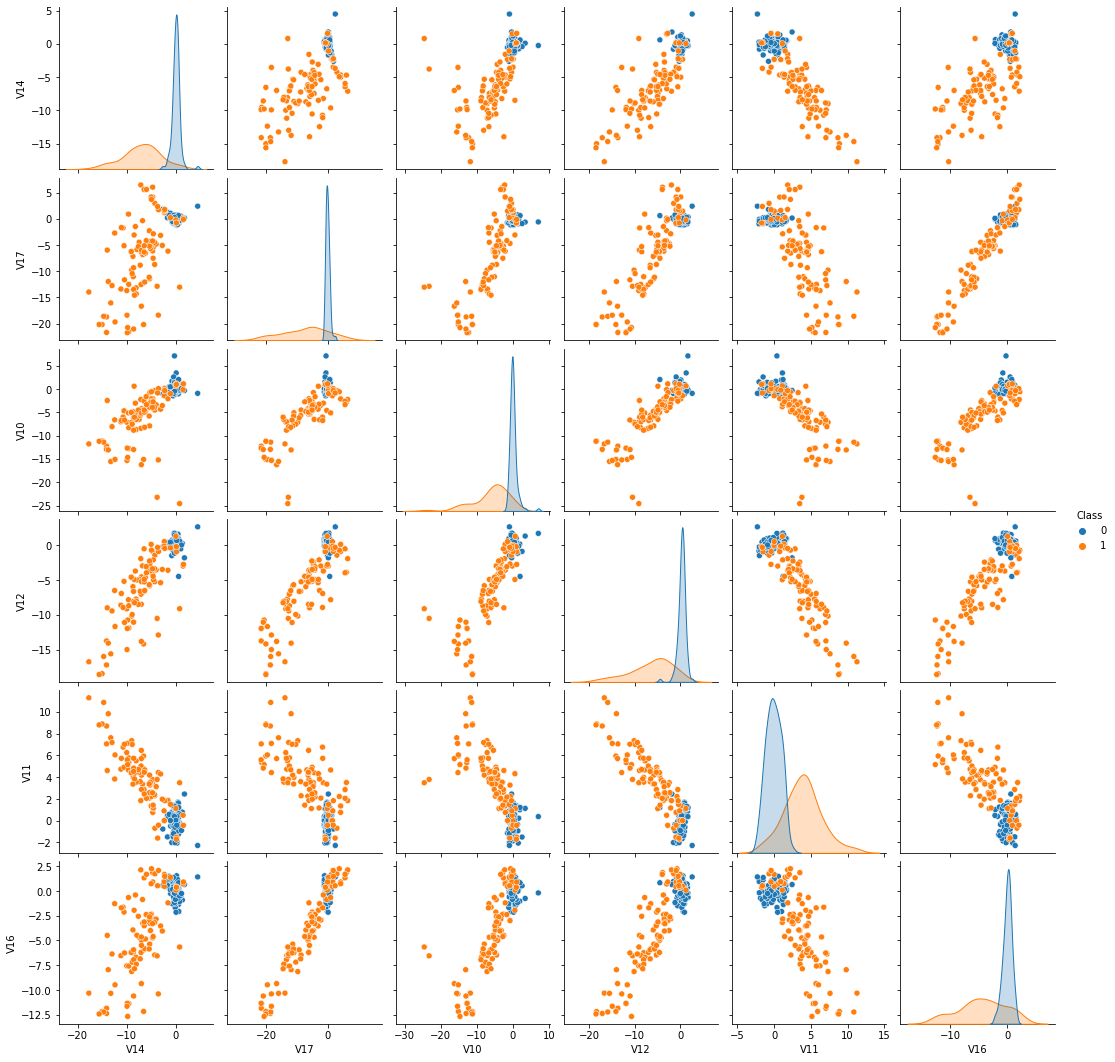

In [5]:
# Recall of each features with two sized Z-score classification with two-sigma cut
dfz = ((abs(df1_train[features]-mu0[features])/sig0[features]) > 2).mean().sort_values(ascending=False)

sorted_feature = dfz.index.tolist()

feature_lead = sorted_feature[:6] ## leading classifying features
feature_insig = sorted_feature[-6:] ## not significantly classifying features

feature_lead.append('Class')
feature_insig.append('Class')

# Significantly classificatory features - high Z score
df_sig = pd.concat([df0_train[feature_lead].sample(n=100),df1_train[feature_lead].sample(n=100)])

sns.pairplot(df_sig, hue="Class")
plt.show()

Note: Keep in mind that the above plots are drawn for equal number of samples for both normal and fraud samples.
With actual highly skewed samples, the distribution of normal sample will have much thicker tails.

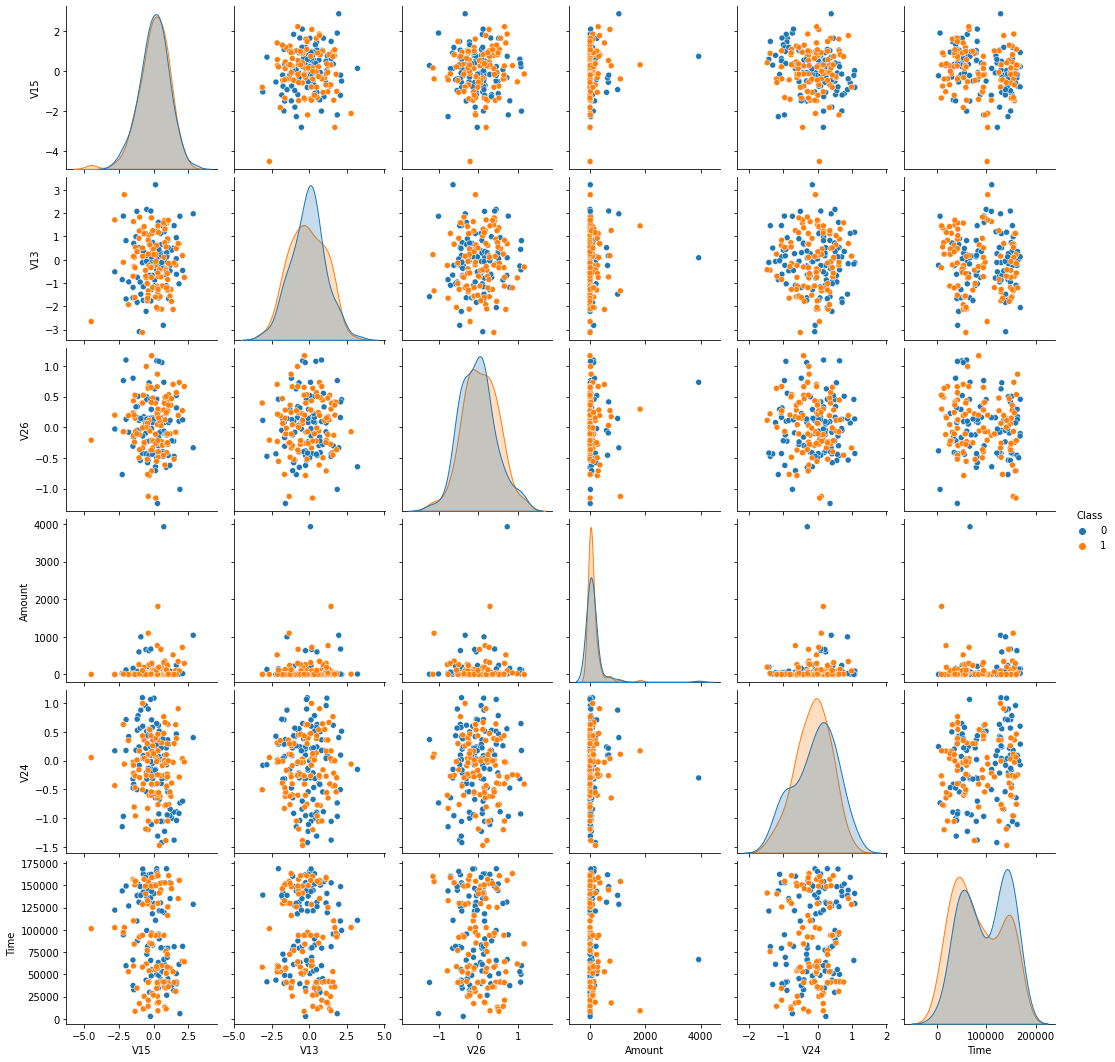

In [6]:
# Inignificantly classificatory features - low Z score
df_insig = pd.concat([df0_train[feature_insig].sample(n=100),df1_train[feature_insig].sample(n=100)])

sns.pairplot(df_insig, hue="Class")
plt.show()

## Define anomaly metric and scoring

$$ Z = \sqrt{\frac{1}{n}\sum^{n~\textrm{leading features}}_{i}~\frac{(Z_{i}-\mu_{i})^2}{\sigma_{i}^2} } > \epsilon $$

In [7]:
# Z-score transform
X_train1 = (df1_train[features]-mu0[features])**2/sig0[features]**2
X_dev0 = (df0_dev[features]-mu0[features])**2/sig0[features]**2
X_dev1 = (df1_dev[features]-mu0[features])**2/sig0[features]**2
X_test0 = (df0_test[features]-mu0[features])**2/sig0[features]**2
X_test1 = (df1_test[features]-mu0[features])**2/sig0[features]**2

y_dev0 = df0_dev.Class
y_dev1 = df1_dev.Class
y_test0 = df0_test.Class
y_test1 = df1_test.Class

X_dev = pd.concat([X_dev0, X_dev1])
y_dev = pd.concat([y_dev0, y_dev1])
X_test = pd.concat([X_test0, X_test1])
y_test = pd.concat([y_test0, y_test1])

# anomaly metric calculation
def metric(X, sig_cut, nfeatures):
    
    # X: squared Z-score

    y_metric = (X.sum(axis=1)/nfeatures)**0.5
    
    y_pred = y_metric.apply(lambda x: 1 if x>sig_cut else 0)
    
    return y_pred

# score calculation
def score(y_pred, y_actual):
    
    def verdict(p,a):
        # predict, actual
        # True/False Positive/Negative
        x=''
    
        if p==0 and a==0:
            x='TN'
        elif p==0 and a==1:
            x='FN'
        elif p==1 and a==0:
            x='FP'
        elif p==1 and a==1:
            x='TP'
        else:
            x='Invalid'
        
        return x
    
    y_score = pd.DataFrame({'predict':y_pred, 'actual':y_actual})
    
    y_score['verdict'] = y_score.apply(lambda x: verdict(x['predict'],x['actual']), axis=1)
    
    tp = y_score[y_score.verdict=='TP'].verdict.count()
    tn = y_score[y_score.verdict=='TN'].verdict.count()
    fp = y_score[y_score.verdict=='FP'].verdict.count()
    fn = y_score[y_score.verdict=='FN'].verdict.count()
    inv = y_score[y_score.verdict=='Invalid'].verdict.count()

    if inv>0 :
        print('Invalid value. Check classification values are all 0 or 1')
        return 0
    
    # Evaluation scores
    precision = tp/(tp+fp)
    recall = tp/(tp+fn) 
    f1score = 2*precision*recall/(precision+recall)
    
    
    #print('TP = {}, TN = {}, FP = {}, FN = {}'.format(tp,tn,fp,fn))

    return y_score.predict, precision, recall, f1score

## Tune hyper parameters

In [8]:
df_hp = pd.DataFrame(columns=['sig_cut','nfeatures','lead_feature','precision','recall','f1score'])
df_y = y_dev.rename('actual').to_frame()

In [9]:
# This part is very slow
for icut in range(1,11):
    
    sig_cut=0.5*icut
    
    print(sig_cut)
    
    # Train to sort leading features in order of "classification power"
    dfz = (X_train1 > sig_cut).mean().sort_values(ascending=False)
    
    sorted_feature = dfz.index.tolist()

    for nfeatures in range(1,31):
        
        lead_feature = sorted_feature[:nfeatures]
        
        y_pred = metric(X_dev[lead_feature], sig_cut, nfeatures)
        result = score(y_pred, y_dev)

        y, p, r, f = result
        
        new_name='predict'+str(icut)+'_'+str(nfeatures)
        
        #print(new_name)

        y = y.rename(new_name).to_frame()#

        
        df_y = pd.merge(df_y, y,left_index=True,right_index=True)
        
        df_hp = df_hp.append({'sig_cut':sig_cut,'nfeatures':nfeatures,'lead_feature':lead_feature,
                              'precision':p,'recall':r,'f1score':f}, ignore_index=True)

0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0


## Visualize tuning result

98 fraud samples


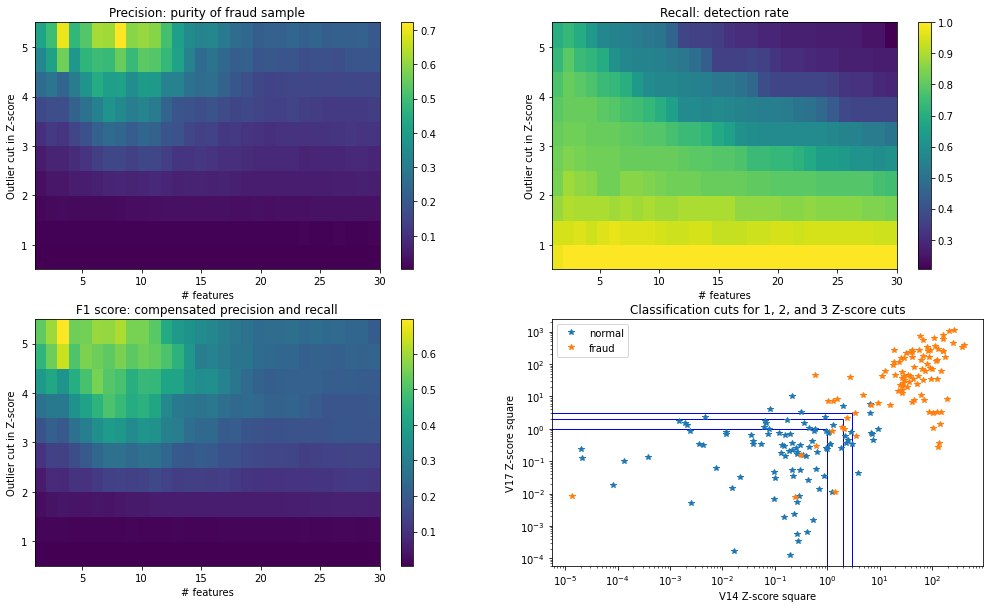

In [10]:
fig = plt.figure(figsize=(17,10))

ax0 = plt.subplot(2, 2, 1)
plt.hist2d(df_hp.nfeatures, df_hp.sig_cut, weights=df_hp.precision, bins=[30,10], range=[[1,30],[0.5,5.5]])
plt.colorbar()
ax0.set_title('Precision: purity of fraud sample')
ax0.set_xlabel('# features')
ax0.set_ylabel('Outlier cut in Z-score')

ax1 = plt.subplot(2, 2, 2)
plt.hist2d(df_hp.nfeatures, df_hp.sig_cut, weights=df_hp.recall, bins=[30,10], range=[[1,30],[0.5,5.5]])
plt.colorbar()
ax1.set_title('Recall: detection rate')
ax1.set_xlabel('# features')
ax1.set_ylabel('Outlier cut in Z-score')

ax2 = plt.subplot(2, 2, 3)
plt.hist2d(df_hp.nfeatures, df_hp.sig_cut, weights=df_hp.f1score, bins=[30,10], range=[[1,30],[0.5,5.5]])
plt.colorbar()
ax2.set_title('F1 score: compensated precision and recall')
ax2.set_xlabel('# features')
ax2.set_ylabel('Outlier cut in Z-score')

n_fraud = len(X_dev1)
print(n_fraud,"fraud samples")
#print('leading features: ',df_hp[(df_hp.sig_cut==2)&(df_hp.nfeatures==30)].iloc[0].lead_feature[:2])

x0=X_dev0.sample(n=n_fraud).V14
y0=X_dev0.sample(n=n_fraud).V17
x1=X_dev1.V14
y1=X_dev1.V17

ax = plt.subplot(2, 2, 4)

plt.plot(x0,y0,'*')
plt.plot(x1,y1,'*')

c1 = plt.Rectangle((0, 0), 1, 1, color='b', fill=False)
c2 = plt.Rectangle((0, 0), 2, 2, color='b', fill=False)
c3 = plt.Rectangle((0, 0), 3, 3, color='b', fill=False)

ax.add_patch(c1)
ax.add_patch(c2)
ax.add_patch(c3)
plt.legend(['normal','fraud'])

ax.set_title('Classification cuts for 1, 2, and 3 Z-score cuts')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('V14 Z-score square')
ax.set_ylabel('V17 Z-score square')

plt.show()

## Interpretation of cross validation scores

### Precision goes higher as the number of leading features increases until it reaches about 10, then decreases

- The more relevant features we use, the detection becomes more strict. 
- When we start to use more irrelevant features, then the detection doesn't enhance fraud selection.

### Precision goes higher as Z-score cut increases

- Assuming normal samples have sharper distribution, higher z-score cut always increases purity of fraud sample.

### Even at the highest, the precision is much lower than 1, due to heavily skewed statistics of classification samples

### Recall goes higher as Z-score cut decreases

- Not all fraud samples are separable from normal samples, so lower Z-score cut will only keep more fraud sample. 
- However the precision is very small in the lowest Z-score area.

### Recall goes higher as the number of leading features decreases, except using only one feature

- For a given Z-score cut, using a few multiple leading features detect more fraud samples than using too many features.

### The highest F1 score is achieved when 2-3 features with highest Z-score cut are applied

- Observation from precision and recall explain this result
- 2-3 leading features do best on ROC curve in the below, too

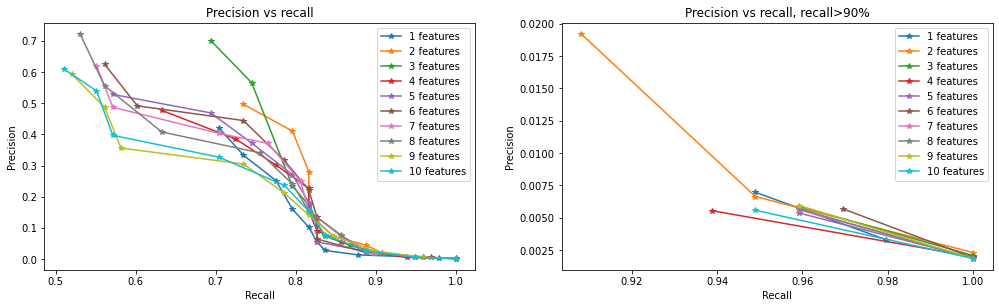

   sig_cut nfeatures    recall  precision
8      0.5         9  1.000000   0.001852
9      0.5        10  1.000000   0.001848
2      0.5         3  1.000000   0.002084
3      0.5         4  1.000000   0.001984
4      0.5         5  1.000000   0.001902
5      0.5         6  1.000000   0.001915
6      0.5         7  1.000000   0.001896
7      0.5         8  1.000000   0.001856
1      0.5         2  1.000000   0.002310
0      0.5         1  0.979592   0.003308
    sig_cut nfeatures    recall  precision
61      1.5         2  0.908163   0.019218
30      1.0         1  0.948980   0.006973
31      1.0         2  0.948980   0.006643
38      1.0         9  0.959184   0.005951
32      1.0         3  0.959184   0.005900
35      1.0         6  0.969388   0.005705
37      1.0         8  0.959184   0.005676
36      1.0         7  0.959184   0.005612
39      1.0        10  0.948980   0.005584
33      1.0         4  0.938776   0.005555
     sig_cut nfeatures    recall  precision
277      5.0         

In [11]:
fig = plt.figure(figsize=(17,10))

ax3 = plt.subplot(2, 2, 1)
lgd=[]
for i in range(1,11):
    plt.plot(df_hp[df_hp.nfeatures==i].recall, df_hp[df_hp.nfeatures==i].precision,'*-')
    lgd.append(str(i)+' features')
plt.legend(lgd)
ax3.set_title('Precision vs recall')
ax3.set_xlabel('Recall')
ax3.set_ylabel('Precision')

ax3 = plt.subplot(2, 2, 2)
lgd=[]
for i in range(1,11):
    plt.plot(df_hp[(df_hp.recall>0.9)&(df_hp.nfeatures==i)].recall, 
             df_hp[(df_hp.recall>0.9)&(df_hp.nfeatures==i)].precision,'*-')
    lgd.append(str(i)+' features')
plt.legend(lgd)
ax3.set_title('Precision vs recall, recall>90%')
ax3.set_xlabel('Recall')
ax3.set_ylabel('Precision')


plt.show()

print(df_hp[(df_hp.recall>0.9)&(df_hp.nfeatures<11)]
      [['sig_cut','nfeatures','recall','precision']].sort_values(by=['recall'],ascending=False).head(10))

print(df_hp[(df_hp.recall>0.9)&(df_hp.nfeatures<11)]
      [['sig_cut','nfeatures','recall','precision']].sort_values(by=['precision'],ascending=False).head(10))

print(df_hp[(df_hp.nfeatures<11)]
      [['sig_cut','nfeatures','recall','precision']].sort_values(by=['precision'],ascending=False).head(10))

print(df_hp[(df_hp.nfeatures<11)]
      [['sig_cut','nfeatures','recall','precision']].sort_values(by=['recall'],ascending=False).head(10))

print(df_hp[['sig_cut','nfeatures','recall','precision','f1score']].sort_values(by=['f1score'],ascending=False).head(10))

## How to select final parameters


### Highest F1 (or F_{\beta}) score is often the best selection. From data, the highest F1 scores are archived by 2-3 leading features with highest Z-score cut. With such selection, the cross validation set shower good performances both in precision (40-60%) and recall (70-90%).

### However, fraudulent transactions are so fatal, so you also want to keep a certain high recall value even though you lose some precision.

### I selected final parameters based on the overall trends, not relying on precise scoring too much. Here are reasons.

- The number of fraud sample has 10% of high statistical error assuming that it follows common probability distributions. Besides, this kind of anomaly sample distributions are chaotic.

- I can imagine that the precision won't be stable for each sampling or over time simply because the frequency of fraudulent transactions won't be regular (if so, it will be interesting…). Here, note that recall might be relatively stable than precision, assuming fraudulent transactions have much broader distribution than normal one, until fraudulent transaction techniques are evolved and become close to normal transactions

### As a conclusion, I suggest two parameter choices with two different kind of “best-overall" performance

## Choice 1 - Highest precision at recall > ~90%

### From cross validation set, top highest precision having recall > 90% were mostly achieved by parameters with a few multiple leading features (2-5 features) and moderately low Z-score cut (1.5-2.5) achieved.

### Test

In [12]:
# Test
lead_feature = df_hp[(df_hp.sig_cut==2)&(df_hp.nfeatures==30)].iloc[0].lead_feature[:2]

y_pred = metric(X_test[lead_feature], 2, 2)
y, p, r, f = score(y_pred, y_test)


print(len(X_test), y.sum(), p,r)

print('precision:',p,'recall:',r,'sampling fraction:',y.sum()/len(X_test))

56962 1962 0.047910295616717634 0.9494949494949495
precision: 0.047910295616717634 recall: 0.9494949494949495 sampling fraction: 0.034444015308451245


### From final test, 88% recall and 3.6% precision (number varies for different samplings) is obtained with 2 leading features and Z-score = 2 cut.

### Evaluation

- System with ~90% recall means that this system catches 90% of fraudulent transaction, which sounds very safe.

- From our model, the precision was a few percent, which is too low to halt (customers will be annoyed), however, quite high to be the first level of sampling.

- The advantage of this sampling is that it reduces the size of "samples to be investigated" significantly without losing most of fraudulent samples, therefore, we can build a several levels of efficient detector.

### Application

- One application example can be building multiple levels of fraud detector, combining faster first level and slower second (or higher) level

- Level 1: Implement this model in as a fast hardware process, for example, add an operation which processes signals of two features and makes logic operation for comparison and decision in a card reader chip. If level1 detect fraud-like transaction, then it halt transaction and send feature signals to level 2

- Level 2: Perform further and slower classification using software or information of higher-up security levels. If this decision says normal, then the transaction will be made (with delays introduced by level 2 processing time), and a customer will hardly notice anything. If this decision says fraud, then we can contact customer to ask security information.


## Choice 2 - Highest F1 score

### Highest F1 scores are achieved by parameters of 2-3 leading features and highest Z-score cut. From cross validation set, such parameters show good performance for both precision (40-60%) and recall (70-90%).

### Test

In [13]:
lead_feature = df_hp[(df_hp.sig_cut==5)&(df_hp.nfeatures==30)].iloc[0].lead_feature[:3]

y_pred = metric(X_test[lead_feature], 5, 3)
y, p, r, f = score(y_pred, y_test)

print('precision:',p,'recall:',r)

precision: 0.7064220183486238 recall: 0.7777777777777778


### From final test, 77% recall and 74% precision (number varies for different samplings) is obtained with 3 leading features and Z-score = 5 cut.

### Evaluation

- This system samples highly fraud-like transactions without losing too much of total fraud transactions. Considering only 0.17% are fraud, 74% of test precision is such a great focusing on crime.

### Application

- One application can be a fast hardware level implementation in a card reader. If a transaction is marked as fraudulent, then the transaction is automatically halt, the transaction information is sent to security monitoring places and/or a staff in a shop can ask further questions to the credit card user. 

## Discussion and Conclusion

- Supervised anomaly detection model based on Z-score is built for fraud detection.

- Two best models are suggested, both perform excellent on test set

- As the trend of normal or fraud transaction changes, the parameters should be adjusted. This model provides intuitive way to tune the parameters.

- Some features might have skewed distribution. In such case, transformation to log might work better.

- Of course, knowing the meaning of each feature will significantly improve the model.